# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! 😊

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

# For exploring audio files
import librosa
import librosa.display
import IPython.display as ipd

sns.set()
BASE_DIR = '../input/birdclef-2022/'
train = pd.read_csv(f'{BASE_DIR}/train_metadata.csv')
test = pd.read_csv(f'{BASE_DIR}/test.csv')
ebird = pd.read_csv(f'{BASE_DIR}/eBird_Taxonomy_v2021.csv')
ss = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

train.head()

primary_label                secondary_labels                     type  \
0       afrsil1                              []  ['call', 'flight call']   
1       afrsil1  ['houspa', 'redava', 'zebdov']                 ['call']   
2       afrsil1                              []         ['call', 'song']   
3       afrsil1                              []   ['alarm call', 'call']   
4       afrsil1                              []          ['flight call']   

   latitude  longitude  scientific_name         common_name          author  \
0   12.3910    -1.4930  Euodice cantans  African Silverbill       Bram Piot   
1   19.8801  -155.7254  Euodice cantans  African Silverbill        Dan Lane   
2   16.2901   -16.0321  Euodice cantans  African Silverbill       Bram Piot   
3   17.0922    54.2958  Euodice cantans  African Silverbill  Oscar Campbell   
4   21.4581  -157.7252  Euodice cantans  African Silverbill   Ross Gallardy   

                                             license  rating   time  \
0  Creative Commons Attribution-NonCommercial-Sha...     2.5  08:00   
1  Creative Commons Attribution-NonCommercial-Sha...     3.5  08:30   
2  Creative Commons Attribution-NonCommercial-Sha...     4.0  11:30   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0  11:00   
4  Creative Commons Attribution-NonCommercial-Sha...     3.0  16:30   

                                 url              filename  
0  https://www.xeno-canto.org/125458  afrsil1/XC125458.ogg  
1  https://www.xeno-canto.org/175522  afrsil1/XC175522.ogg  
2  https://www.xeno-canto.org/177993  afrsil1/XC177993.ogg  
3  https://www.xeno-canto.org/205893  afrsil1/XC205893.ogg  
4  https://www.xeno-canto.org/207431  afrsil1/XC207431.ogg

In [2]:
train.isna().sum()

primary_label       0
secondary_labels    0
type                0
latitude            0
longitude           0
scientific_name     0
common_name         0
author              0
license             0
rating              0
time                0
url                 0
filename            0
dtype: int64

In [3]:
train['time_dt'] = pd.to_datetime(train['time'], errors='coerce')
train['time_dt'] = train['time_dt'].dt.round('30min')
train['time_H_M'] = train['time_dt'].dt.strftime('%H:%M')
print('Error Times :', train['time_dt'].isna().sum())

Error Times : 603


In [4]:
train.loc[train['time_dt'].isna(), ['time', 'time_H_M']].head()

time time_H_M
182  xx:xx      NaN
183  xx:xx      NaN
184  xx:xx      NaN
185      ?      NaN
191      ?      NaN

In [5]:
train.dtypes

primary_label               object
secondary_labels            object
type                        object
latitude                   float64
longitude                  float64
scientific_name             object
common_name                 object
author                      object
license                     object
rating                     float64
time                        object
url                         object
filename                    object
time_dt             datetime64[ns]
time_H_M                    object
dtype: object

In [6]:
train.duplicated().sum()

0

In [7]:
def seperate_list_col(str_list, max_len=6):
    if str_list != '[]':
        seperated_list = str_list.split(',')
        seperated_list[0] = seperated_list[0][1:]
        seperated_list[-1] = seperated_list[-1][:-1]
        seperated_list.extend([None] * (6 - len(seperated_list)))
        return seperated_list
    else:
        return [None] * max_len

In [8]:
train['secondary_label_len'] = train['secondary_labels'].apply(lambda x: len(x.split(',')))
train['type_len'] = train['type'].apply(lambda x: len(x.split(',')))

In [9]:
values_secondary_labels = train['secondary_labels'].apply(lambda x: seperate_list_col(x, max_len=6))
df_secondary_labels = pd.DataFrame(values_secondary_labels.to_list(), columns=['l2', 'l3', 'l4', 'l5', 'l6', 'l7'])
df_secondary_labels.head()

l2         l3         l4    l5    l6    l7
0      None       None       None  None  None  None
1  'houspa'   'redava'   'zebdov'  None  None  None
2      None       None       None  None  None  None
3      None       None       None  None  None  None
4      None       None       None  None  None  None

In [10]:
train['secondary_label_len'] = np.where(df_secondary_labels['l2'].values != None, train['secondary_label_len'], 0)

In [11]:
values_type = train['type'].apply(lambda x: seperate_list_col(x, max_len=9))
df_type = pd.DataFrame(values_type.to_list(), columns=['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9'])
df_type.head()

t1              t2    t3    t4    t5    t6    t7    t8    t9
0         'call'   'flight call'  None  None  None  None  None  None  None
1         'call'            None  None  None  None  None  None  None  None
2         'call'          'song'  None  None  None  None  None  None  None
3   'alarm call'          'call'  None  None  None  None  None  None  None
4  'flight call'            None  None  None  None  None  None  None  None

In [12]:
train['type_len'] = np.where(df_type['t1'].values != None, train['type_len'], 0)

# Distributions

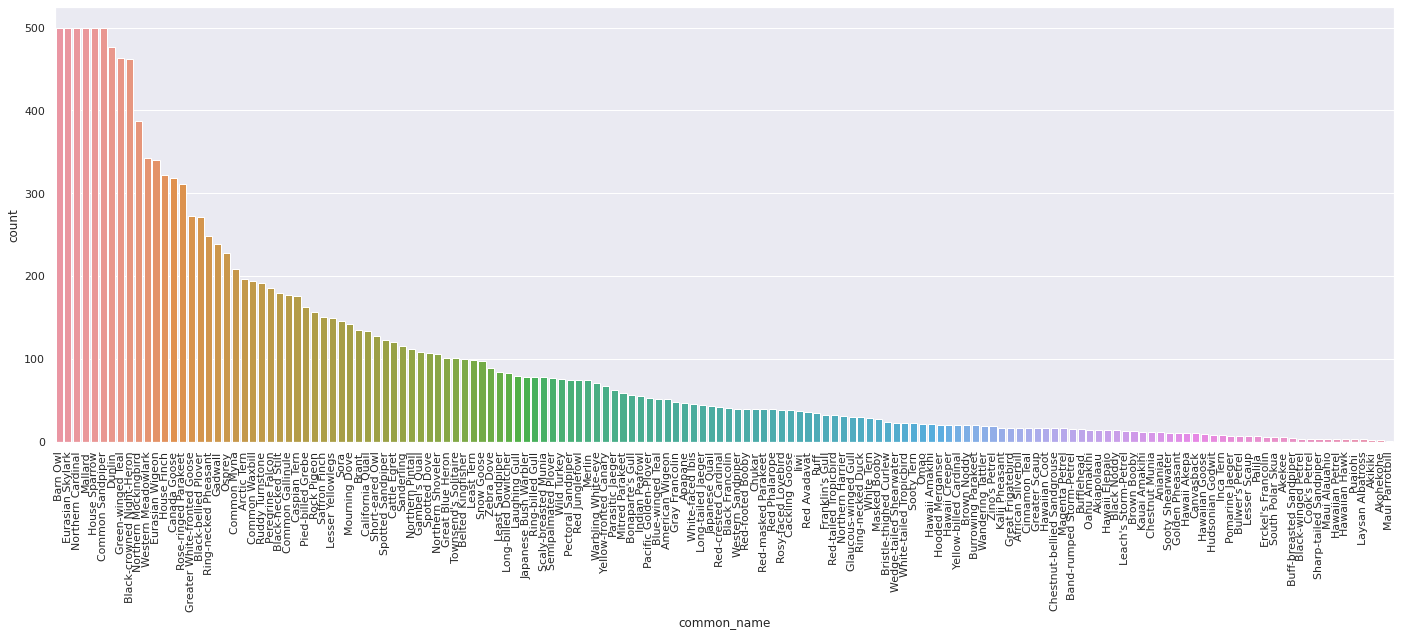

In [13]:
fig, ax = plt.subplots(figsize=(24, 8))
sns.countplot(data=train, x='common_name', ax=ax, order=train['common_name'].value_counts().index)
plt.xticks(rotation=90);

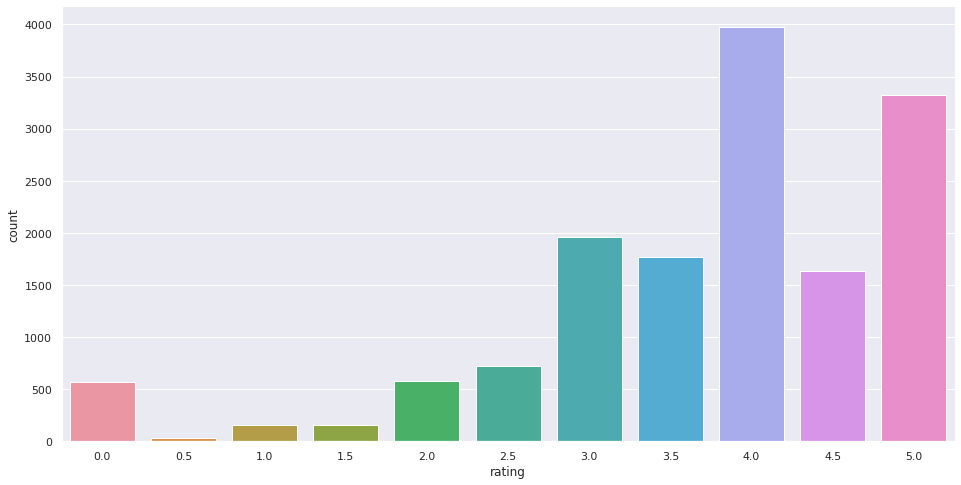

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(data=train, x='rating', ax=ax);

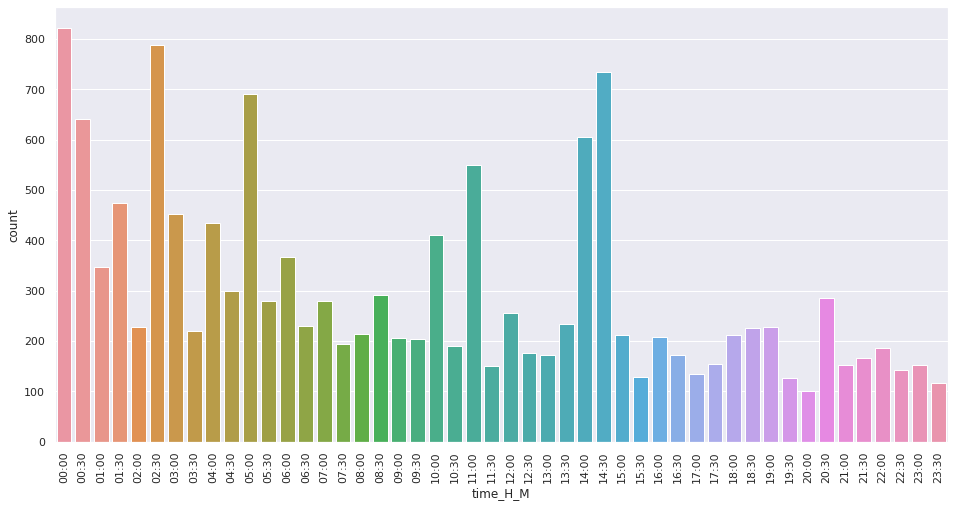

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
x_labels = pd.date_range(start='00:00', periods=48, freq='30min')
x_labels = list(x_labels.strftime('%H:%M'))
sns.countplot(data=train, x='time_H_M', ax=ax)
ax.set_xticklabels(x_labels, rotation=90);

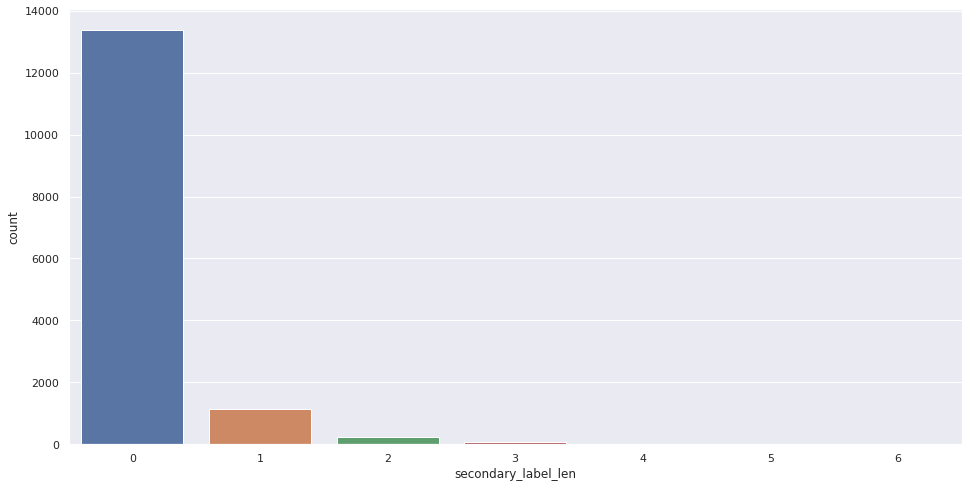

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(data=train, x='secondary_label_len', ax=ax);

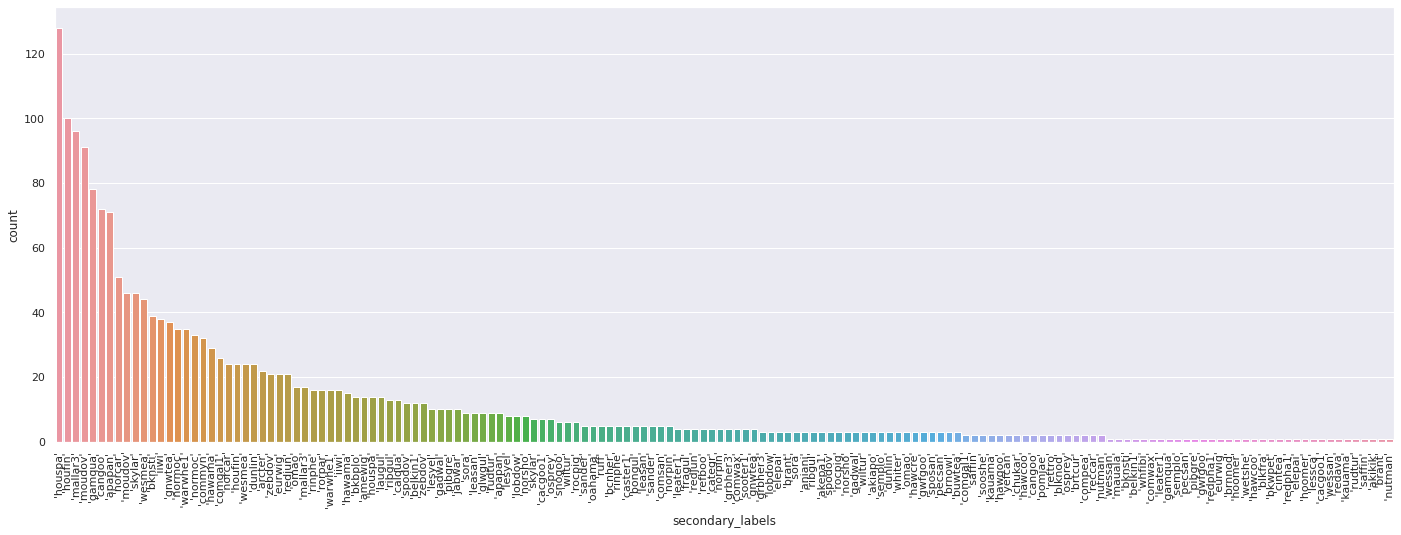

In [17]:
values = [df_secondary_labels[col].values.tolist() for col in df_secondary_labels.columns]
values = np.array(values)
df_values = pd.DataFrame(values.flatten(), columns=['secondary_labels'])

fig, ax = plt.subplots(figsize=(24, 8))
sns.countplot(data = df_values, x='secondary_labels', ax=ax, order=df_values['secondary_labels'].value_counts().index)
plt.xticks(rotation=90);

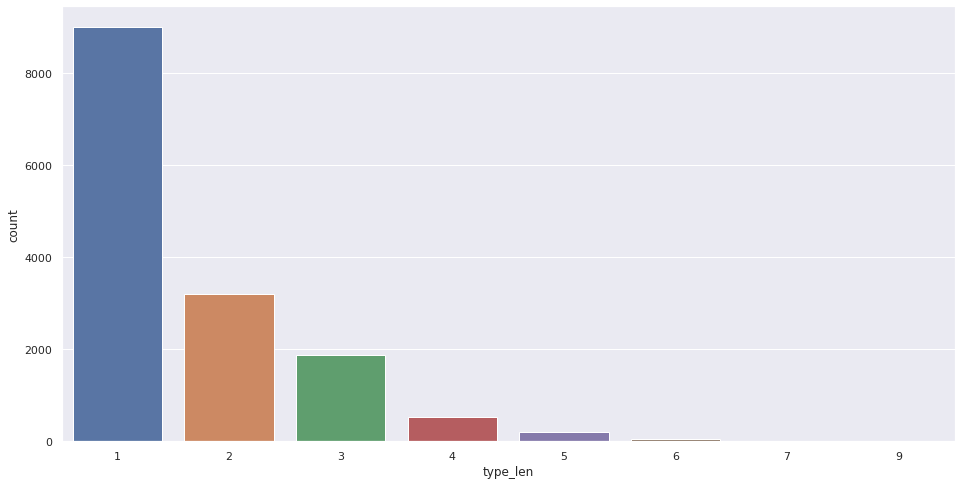

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(data=train, x='type_len', ax=ax);

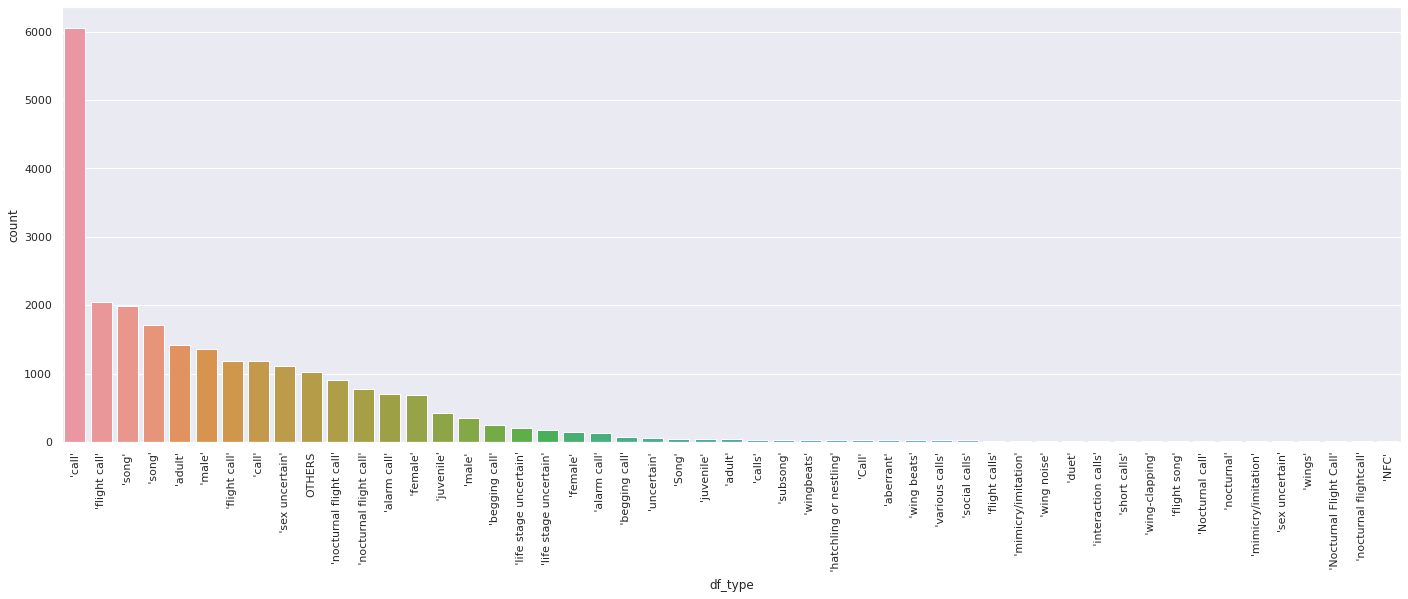

In [19]:
values = [df_type[col].values.tolist() for col in df_type.columns]
values = np.array(values)
df_values = pd.DataFrame(values.flatten(), columns=['df_type'])
th = 10
counts = df_values['df_type'].value_counts()
ignore_values = counts[counts < th].index
df_values.loc[df_values['df_type'].isin(ignore_values), 'df_type'] = 'OTHERS'

fig, ax = plt.subplots(figsize=(24, 8))
sns.countplot(data = df_values, x='df_type', ax=ax, order=df_values['df_type'].value_counts().index)
plt.xticks(rotation=90);

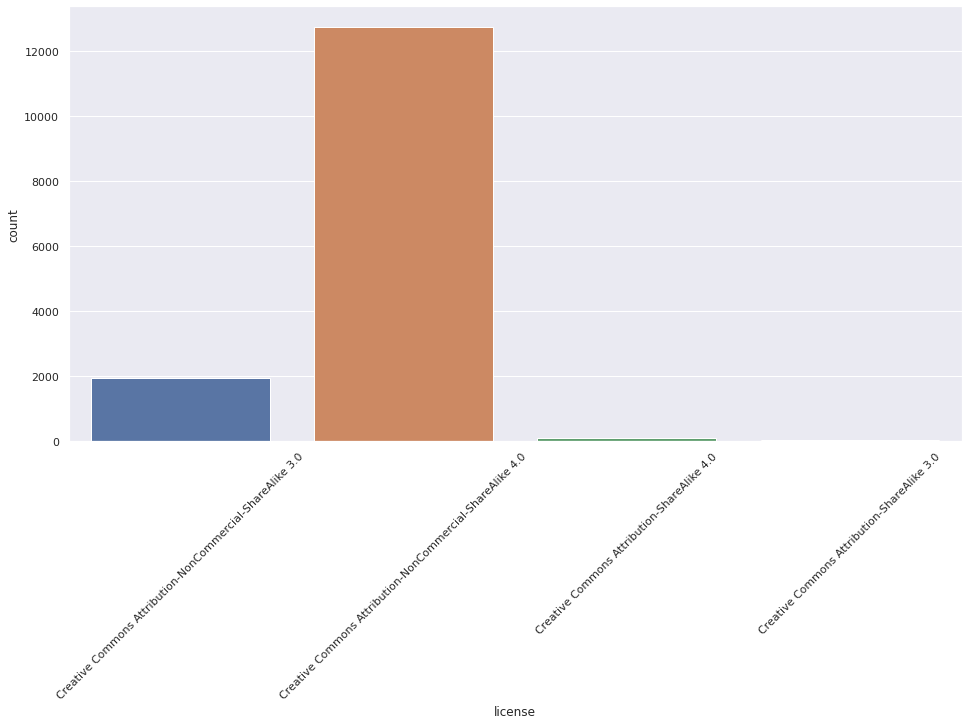

In [20]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(data=train, x='license', ax=ax)
plt.xticks(rotation=45);

In [21]:
fig = px.scatter_geo(
    train,
    lat="latitude",
    lon="longitude",
    color="common_name",
    width=1_000,
    height=500,
    title="BirdCLEF 2022 Training Data",
)
fig.show()

# Noise Reduction

"Noise reduction is the process of removing noise from a signal. Noise reduction techniques exist for audio and images. Noise reduction algorithms may distort the signal to some degree." [Source](https://en.wikipedia.org/wiki/Noise_reduction)

In this work, we use a low pass filter for noise reduction. We can control noise reduction rate by changin **"th"** parameter.

In [22]:
# Listen to the audio for the second training example
fn = train["filename"].values[1]
ipd.Audio(f"{BASE_DIR}train_audio/{fn}")

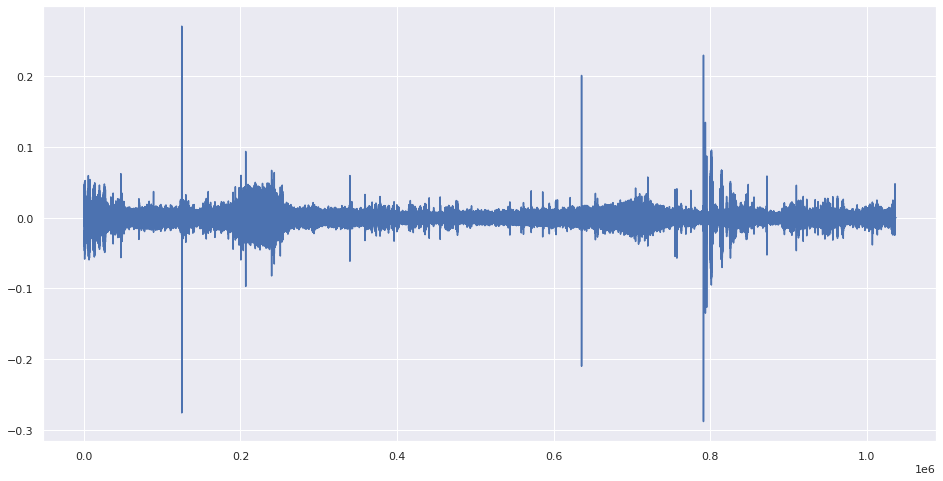

In [23]:
y, sr = librosa.load(f"{BASE_DIR}train_audio/{fn}")
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=np.arange(len(y)), y=y, ax=ax);

In [24]:
def noise_reduction(y, sr, plot=True, th=0.3):
    from scipy.fft import fft, fftfreq, ifft
    
    SAMPLE_RATE = 1
    DURATION = len(y) / SAMPLE_RATE
    N = int(SAMPLE_RATE * DURATION)

    yf = fft(y)
    xf = fftfreq(N, 1 / SAMPLE_RATE)
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(24, 8))
        axes[0].plot(np.arange(len(y)), y)
        axes[0].set_title('Before Time-Domain')
        axes[1].plot(xf, np.abs(yf))
        axes[1].set_title('Before Frequency-Domain')
        plt.show()
    
    # Filtering Low-Pass
    new_yf = yf.copy()
    middle = len(y) / 2
    new_yf[int(middle - len(y) * th):int(middle + len(y) * th)] = 0
    new_y = ifft(new_yf)
    new_y = new_y.real
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(24, 8))
        axes[0].plot(np.arange(len(y)), new_y)
        axes[0].set_title('After Time-Domain')
        axes[1].plot(xf, np.abs(new_yf))
        axes[1].set_title('After Frequency-Domain')
        plt.show()
    
    return new_y, sr

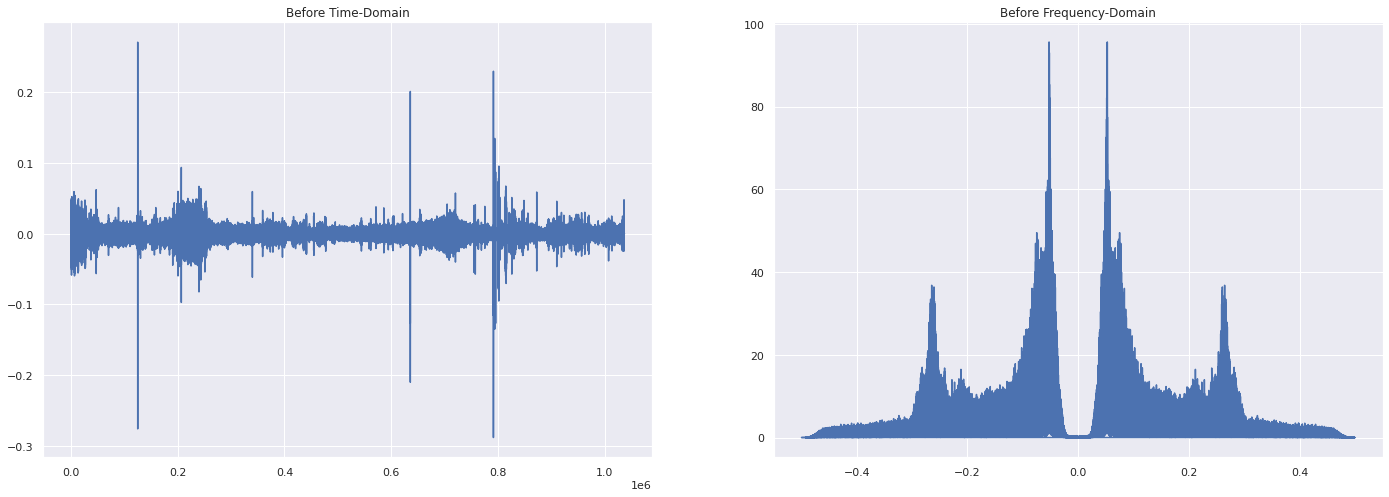

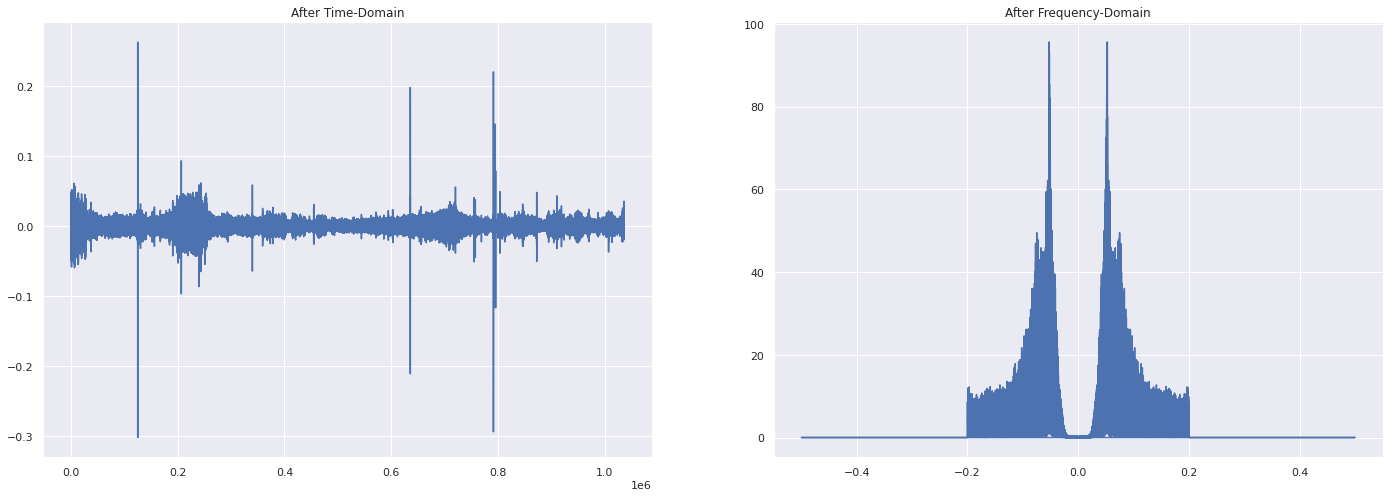

In [25]:
new_y, sr = noise_reduction(y, sr, plot=True, th=0.3)

In [26]:
display("Old Audio", ipd.Audio(data=y, rate=sr))
display("New Audio", ipd.Audio(data=new_y, rate=sr))

'Old Audio'

'New Audio'